In [1]:
from typing import Tuple, Sequence
from dataclasses import dataclass

import pandas as pd
import torch
import torch.nn.functional as F
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error
from torchmetrics.functional import concordance_corrcoef

import seaborn as sns

from vae import VariationAutoencoderModule, WassersteinLoss, MultiCategoricalLoss
from data import UpdrsDataQoL, UpdrsDataModule

## Fit the model

NAME = "updrs_qol_vae_new"

data = UpdrsDataQoL(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp.csv"
)
data_module = UpdrsDataModule(
    data,
    percentage_subjects_in_valid_dataset=0.2,
    batch_size=512,
)
print(len(data_module.train_dataloader()))
print(len(data_module.val_dataloader()))

reconstruction_loss = MultiCategoricalLoss(
    n_values=len(UpdrsDataQoL.COLUMNS),
    n_classes=5,
    is_categorical=False,
    is_ordinal=True,
    weight=data_module.calculate_class_weights().to("cuda"),
)
# generative_loss = KullbackLeiblerLoss(beta=1.0)
generative_loss = WassersteinLoss(reg_weight=100, kernel_type="imq", z_var=2.0)
model = VariationAutoencoderModule(
    reconstruction_loss,
    generative_loss,
    [64, 48, 32, 16],
    patience=80,
    learning_rate=1e-3,
    dropout=0.05,
)
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename=NAME,
    save_top_k=1,
    verbose=True,
    monitor="val_concordance",
    mode="max",
)
early_stopping = EarlyStopping(monitor="val_concordance", patience=120, mode="max")
logger = TensorBoardLogger("logs", name=NAME)

# Initialize the PyTorch Lightning trainer
trainer = L.Trainer(
    max_epochs=1000, callbacks=[early_stopping], logger=logger, log_every_n_steps=6
)

trainer.fit(model, data_module)

## Evaluate the model

In [2]:
model = VariationAutoencoderModule.load_from_checkpoint(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/src/checkpoints_val_loss/updrs_qol_optuna_val_loss_52.ckpt"
).model.eval()

### Check its applicability for PDQ prediction

In [3]:
MAX_SCORES = {
    "Mobility": 40,
    "Daily living": 24,
    "Emotion": 24,
    "Stigmatization": 16,
    "Social support": 12,
    "Cognition": 16,
    "Communication": 12,
    "Bodily discomfort": 12,
}
TARGET_COLUMNS = list(MAX_SCORES.keys())

X_amp = pd.read_csv("../data/pdq_amp.csv", na_values="Unknown")
X_amp.columns = X_amp.columns.str.replace("ADL", "Daily living", regex=False)
X_amp.columns = X_amp.columns.str.replace("Stigma", "Stigmatization", regex=False)
X_amp.columns = X_amp.columns.str.replace("Social", "Social support", regex=False)
X_amp.columns = X_amp.columns.str.replace(
    "Discomfort", "Bodily discomfort", regex=False
)

value_map = {
    "Never": 0,
    "Occasionally": 1,
    "Sometimes": 2,
    "Often": 3,
    "Always or cannot do at all": 4,
}

# Convert relevant columns using the map to numerical values
for col in X_amp.columns:
    if col.startswith("PDQ39"):
        X_amp[col] = X_amp[col].map(value_map).astype(pd.Int64Dtype())

for key, value in MAX_SCORES.items():
    selected_columns = X_amp.filter(like=key)
    assert len(selected_columns.columns) * 4 == value
    X_amp[key] = selected_columns.sum(axis=1, skipna=False)
    X_amp[key] = (X_amp[key] * 100) / value
    X_amp = X_amp.drop(columns=selected_columns.columns)

# Cast the UPDRS scoresx
for col in X_amp.columns:
    if col.startswith("UPDRS"):
        X_amp[col] = X_amp[col].astype(pd.Int64Dtype())
X_amp = X_amp.drop(columns=["MoCA", "UPDRS I", "UPDRS II", "UPDRS III"])

UPDRS_I_columns = X_amp.filter(like="UPDRS 1.")
UPDRS_II_columns = X_amp.filter(like="UPDRS 2.")
UPDRS_IV_columns = X_amp.filter(like="UPDRS 4.")

X_amp["PDQ"] = X_amp[TARGET_COLUMNS].mean(axis=1)
X_amp = X_amp.dropna(subset=["PDQ"])

X_amp["UPDRS I"] = (
    UPDRS_I_columns.sum(axis=1, skipna=False) / (len(UPDRS_I_columns.columns) * 4)
) * 100
X_amp["UPDRS II"] = (
    UPDRS_II_columns.sum(axis=1, skipna=False) / (len(UPDRS_II_columns.columns) * 4)
) * 100
X_amp["UPDRS IV"] = (
    UPDRS_IV_columns.sum(axis=1, skipna=False) / (len(UPDRS_IV_columns.columns) * 4)
) * 100

y_amp = pd.DataFrame.from_dict({"PDQ": X_amp["PDQ"]})
y_amp[TARGET_COLUMNS] = X_amp[TARGET_COLUMNS]

X_amp = X_amp.drop(columns=TARGET_COLUMNS + ["PDQ"])

In [4]:
MODEL_COLUMNS = [
    column
    for column in X_amp.columns
    if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")
]
complete_records = ~X_amp[MODEL_COLUMNS].isna().any(axis=1)
X = X_amp.loc[complete_records, MODEL_COLUMNS].to_numpy().astype(float)
y = y_amp.loc[complete_records, "PDQ"].to_numpy()


X_feature = (
    model(torch.tensor(X, dtype=torch.float32).to("cuda"))
    .z_dist.loc.cpu()
    .detach()
    .numpy()
)

folds = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
representation_results = []
for name, regressor in {
    "Linear": LinearRegression(),
    "Ensemble": HistGradientBoostingRegressor(loss="absolute_error"),
}.items():
    for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
        regressor.fit(X_feature[train_index], y[train_index])
        representation_results.append(
            pd.DataFrame(
                {
                    "Ground truth": y[test_index],
                    "Prediction": regressor.predict(X_feature[test_index]),
                    "Method": name,
                    "Fold": fold,
                }
            )
        )

representation_results = pd.concat(representation_results).reset_index(drop=True)
representation_results["Input"] = "Representation"

representation_results

,Ground truth,Prediction,Method,Fold,Input
0,31.197917,20.621248,Linear,0,Representation
1,25.416667,10.822554,Linear,0,Representation
2,15.677083,12.808875,Linear,0,Representation
3,25.833333,10.324508,Linear,0,Representation
4,30.520833,17.010324,Linear,0,Representation
...,...,...,...,...,...
6457,5.781250,5.632360,Ensemble,9,Representation
6458,1.041667,9.134946,Ensemble,9,Representation
6459,3.125000,4.557881,Ensemble,9,Representation
6460,4.479167,3.817324,Ensemble,9,Representation


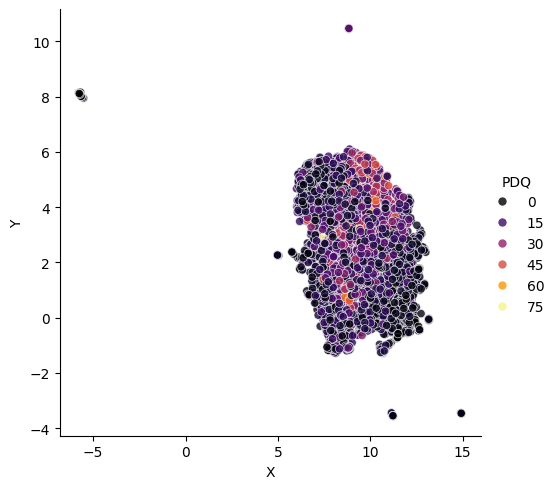

In [5]:
from umap import UMAP

# projected_data = pd.DataFrame.from_records(UMAP(n_neighbors=25, min_dist=0.01, n_components=2, target_metric="l1").fit_transform(X_feature, y=df_amp[["UPDRS I", "UPDRS II"]].sum(axis=1).to_numpy()), columns=["X", "Y"])

projected_data = pd.DataFrame.from_records(
    UMAP(n_neighbors=10, min_dist=0.1, n_components=2).fit_transform(X_feature),
    columns=["X", "Y"],
)
projected_data["PDQ"] = y
sns.relplot(data=projected_data, x="X", y="Y", hue="PDQ", alpha=0.8, palette="inferno")

In [6]:
@dataclass
class PredictionTask:
    combined: Sequence[str]
    individual: Sequence[str]
    input_type: str

    def predict(
        self,
        X_amp: pd.DataFrame,
        y_amp: pd.DataFrame,
        y_variable: str = "PDQ",
        covariates: Sequence[str] = ()
    ) -> pd.DataFrame:
        # Identify those records that have complete data
        complete_records = ~X_amp[
            self.individual + self.combined + list(covariates)
        ].isna().any(axis=1) & ~pd.isna(y_amp[y_variable])

        print(f"{y_variable}: {complete_records.sum()}/{len(complete_records)} complete")
        X = X_amp.loc[
            complete_records,
            self.individual + self.combined + list(covariates),
        ]
        y = y_amp.loc[complete_records, y_variable].to_numpy()
        folds = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)

        results = []

        # Check the baseline condition on scores
        for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
            regressor = LinearRegression()
            regressor.fit(X[self.combined].iloc[train_index], y[train_index])
            results.append(
                pd.DataFrame(
                    {
                        "Ground truth": y[test_index],
                        "Prediction": regressor.predict(
                            X[self.combined].iloc[test_index]
                        ),
                        "Method": "Linear (score)",
                        "Fold": fold,
                    }
                )
            )

        # Remove the total scores
        X = X.drop(columns=self.combined)

        # Use the individual values
        for name, regressor in {
            "Linear": LinearRegression(),
            "Ensemble": HistGradientBoostingRegressor(loss="absolute_error"),
        }.items():
            for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
                regressor.fit(X.iloc[train_index], y[train_index])
                results.append(
                    pd.DataFrame(
                        {
                            "Ground truth": y[test_index],
                            "Prediction": regressor.predict(X.iloc[test_index]),
                            "Method": name,
                            "Fold": fold,
                        }
                    )
                )

        result = pd.concat(results)
        result["Input"] = self.input_type
        return result


prediction_updrs_i = PredictionTask(
    combined=["UPDRS I"],
    individual=[
        column for column in X_amp.columns if column.startswith("UPDRS 1.")
    ],
    input_type="UPDRS I only",
)

prediction_updrs_ii = PredictionTask(
    combined= ["UPDRS I", "UPDRS II"],
    individual=[
        column
        for column in X_amp.columns
        if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")
    ],
    input_type="UPDRS I and II",
)

prediction_updrs_iv = PredictionTask(
    combined= ["UPDRS I", "UPDRS II", "UPDRS IV"],
    individual=[
        column
        for column in X_amp.columns
        if column.startswith("UPDRS 1.")
        or column.startswith("UPDRS 2.")
        or column.startswith("UPDRS 4.")
    ],
    input_type="UPDRS I, II and IV",
)

In [7]:
COVARIATES = ["Age"]

result_without_covariates = pd.concat(
    [prediction_updrs_i.predict(X_amp, y_amp), prediction_updrs_ii.predict(X_amp, y_amp), prediction_updrs_iv.predict(X_amp, y_amp), representation_results]
)
result_without_covariates["Covariates"] = "None"

result_with_covariates = pd.concat(
    [prediction_updrs_i.predict(X_amp, y_amp, covariates=COVARIATES), prediction_updrs_ii.predict(X_amp, y_amp, covariates=COVARIATES), prediction_updrs_iv.predict(X_amp, y_amp, covariates=COVARIATES), representation_results]
)
result_with_covariates["Covariates"] = "Age"

result = pd.concat([result_without_covariates, result_with_covariates])

PDQ: 3234/3338 complete
PDQ: 3231/3338 complete
PDQ: 2277/3338 complete
PDQ: 3234/3338 complete
PDQ: 3231/3338 complete
PDQ: 2277/3338 complete


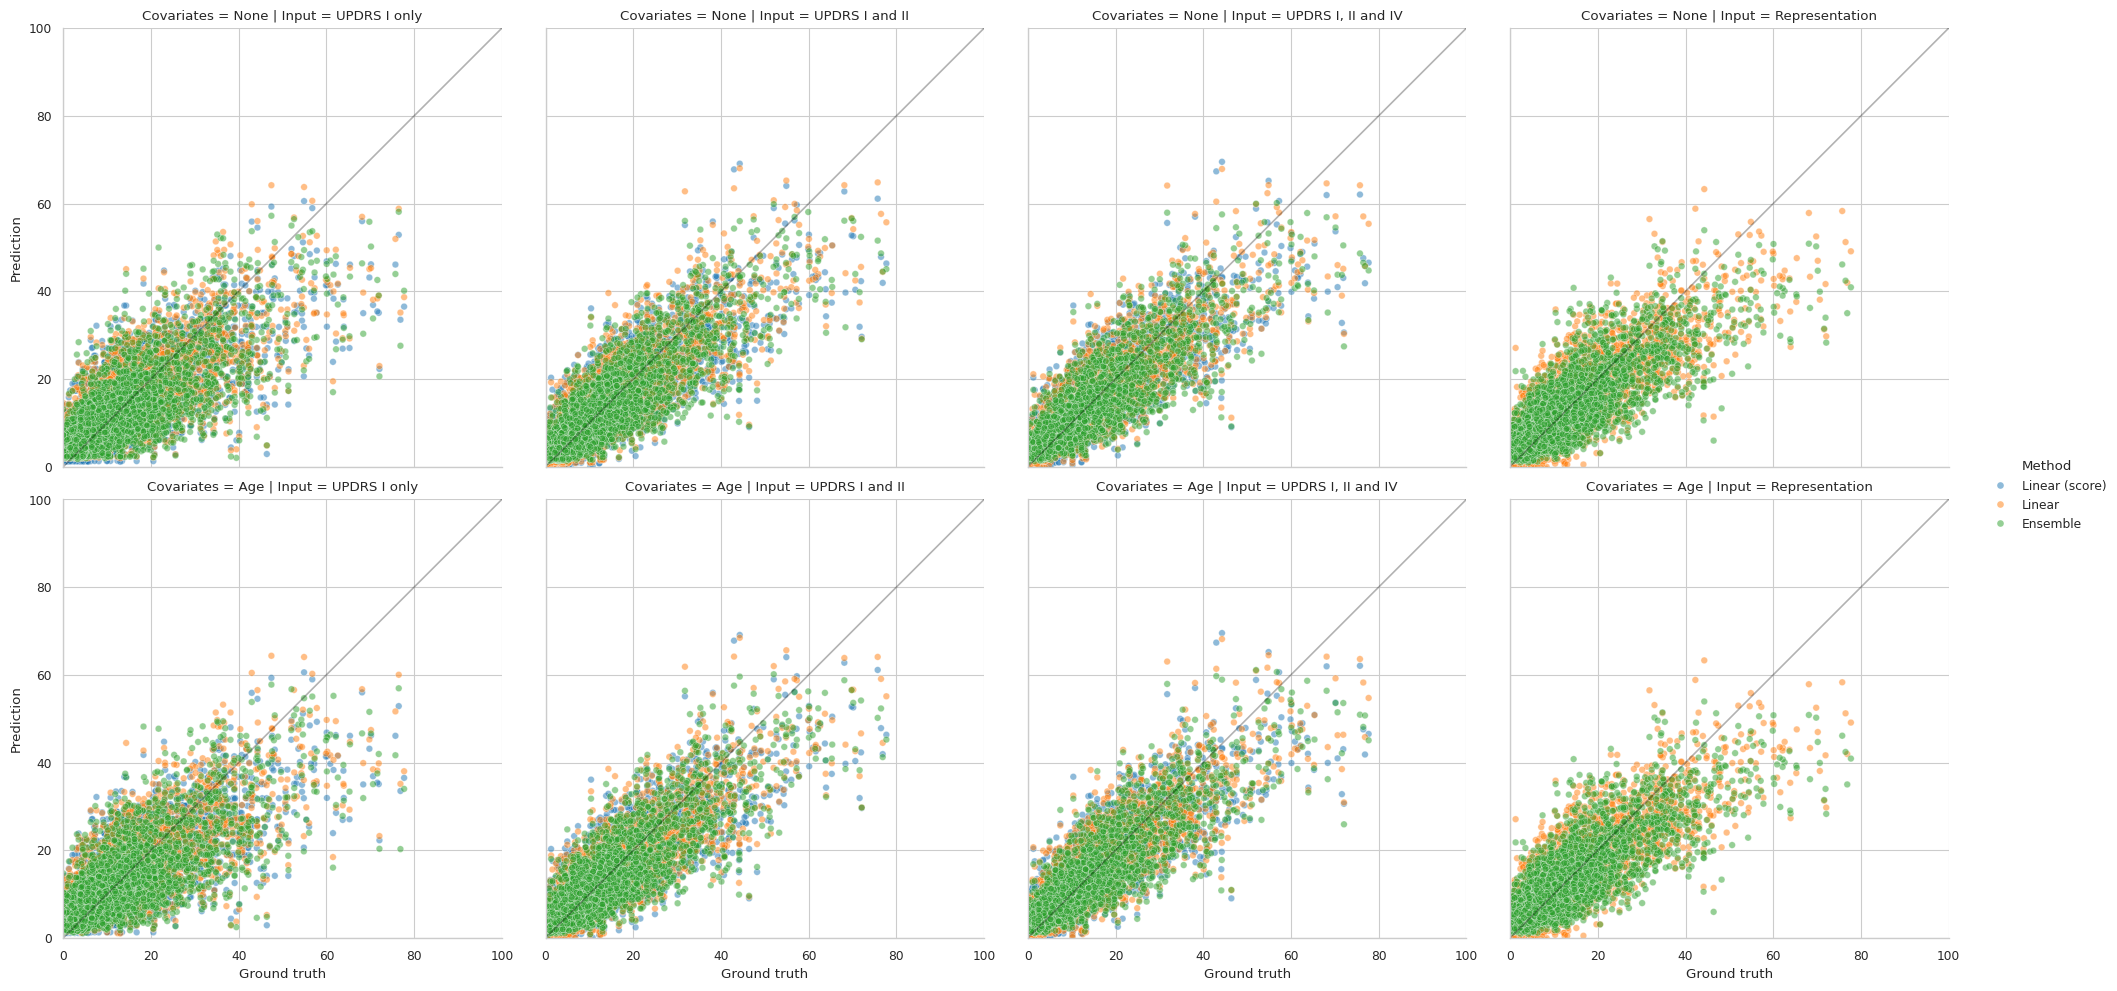

In [8]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    grid = sns.relplot(
        data=result,
        x="Ground truth",
        y="Prediction",
        hue="Method",
        col="Input",
        row="Covariates",
        alpha=0.5,
    )
    grid.set(xlim=(0, 100), ylim=(0, 100), aspect="equal")
    for ax in grid.axes.flatten():
        ax.plot([0, 100], [0, 100], color="black", linestyle="-", alpha=0.3)

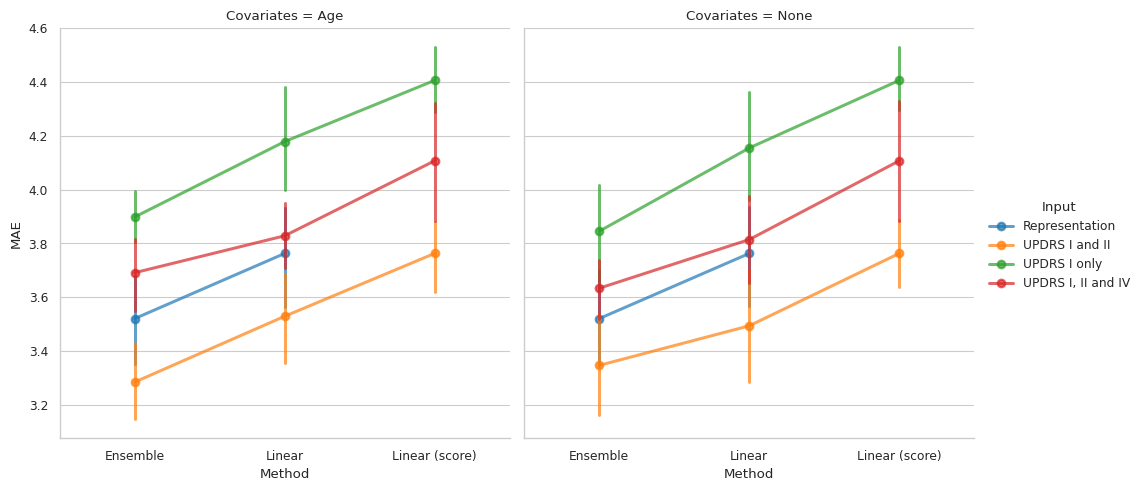

In [9]:
median_absolute_error_agg = []
for covariates, covariates_data in result.groupby("Covariates"):
    for input, input_data in covariates_data.groupby("Input"):
        for name, method_data in input_data.groupby("Method"):
            folds = method_data.groupby("Fold")
            median_absolute_error_agg.append(
                pd.DataFrame.from_dict(
                    {
                        "Method": name,
                        "Input": input,
                        "MAE": [
                            median_absolute_error(
                                y_true=fold["Ground truth"],
                                y_pred=fold["Prediction"],
                            )
                            for _, fold in folds
                        ],
                        "Covariates": covariates,
                        "Fold": range(len(folds)),
                    }
                )
            )
median_absolute_error_agg = pd.concat(median_absolute_error_agg)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.catplot(
        data=median_absolute_error_agg,
        x="Method",
        y="MAE",
        hue="Input",
        alpha=0.7,
        kind="point",
        col="Covariates",
    )

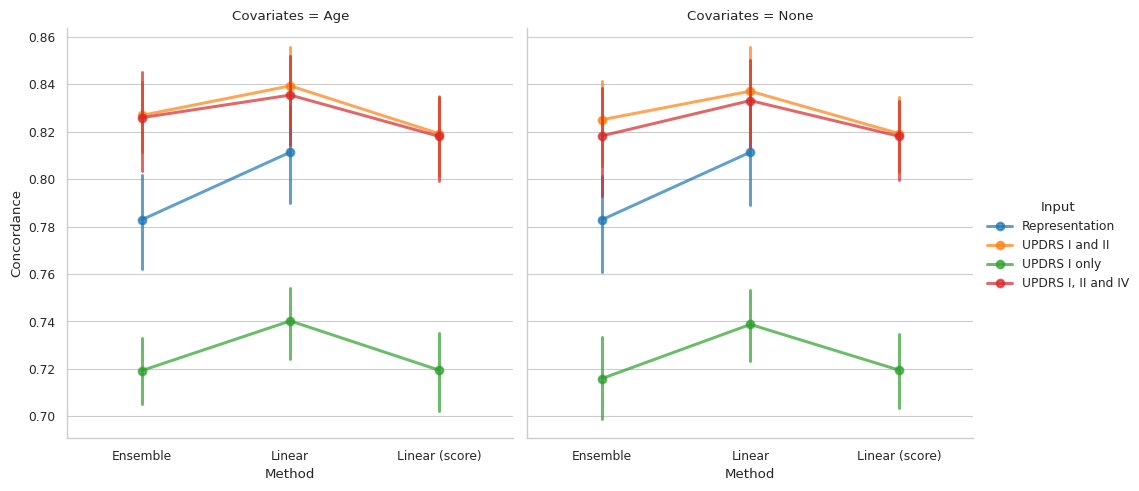

In [10]:
concordance_agg = []
for (method, input_data, covariates), data in result.groupby(
    ["Method", "Input", "Covariates"]
):
    concordance = [
        float(
            concordance_corrcoef(
                preds=torch.tensor(fold["Prediction"].to_numpy()),
                target=torch.tensor(fold["Ground truth"].to_numpy()),
            )
        )
        for _, fold in data.groupby("Fold")
    ]
    concordance_agg.append(
        pd.DataFrame.from_dict(
            {
                "Method": method,
                "Input": input_data,
                "Concordance": concordance,
                "Covariates": covariates,
            }
        )
    )

concordance_agg = pd.concat(concordance_agg)
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.catplot(
        data=concordance_agg,
        x="Method",
        y="Concordance",
        hue="Input",
        alpha=0.7,
        kind="point",
        col="Covariates",
    )

## Test the subscores

In [11]:
SUBSCORES = [
    "Mobility",
    "Daily living",
    "Emotion",
    "Stigmatization",
    "Social support",
    "Cognition",
    "Communication",
    "Bodily discomfort",
]

subscores_results = []
for subscore in SUBSCORES:
    subscore_results = pd.concat(
        [prediction_updrs_i.predict(X_amp, y_amp, y_variable=subscore), prediction_updrs_ii.predict(X_amp, y_amp, y_variable=subscore), prediction_updrs_iv.predict(X_amp, y_amp, y_variable=subscore)]
    )
    subscore_results["Subscore"] = subscore
    subscores_results.append(subscore_results)
subscores_results = pd.concat(subscores_results).reset_index(drop=True)

Mobility: 3234/3338 complete
Mobility: 3231/3338 complete
Mobility: 2277/3338 complete
Daily living: 3234/3338 complete
Daily living: 3231/3338 complete
Daily living: 2277/3338 complete
Emotion: 3234/3338 complete
Emotion: 3231/3338 complete
Emotion: 2277/3338 complete
Stigmatization: 3234/3338 complete
Stigmatization: 3231/3338 complete
Stigmatization: 2277/3338 complete
Social support: 2729/3338 complete
Social support: 2727/3338 complete
Social support: 1818/3338 complete
Cognition: 3234/3338 complete
Cognition: 3231/3338 complete
Cognition: 2277/3338 complete
Communication: 3234/3338 complete
Communication: 3231/3338 complete
Communication: 2277/3338 complete
Bodily discomfort: 3234/3338 complete
Bodily discomfort: 3231/3338 complete
Bodily discomfort: 2277/3338 complete


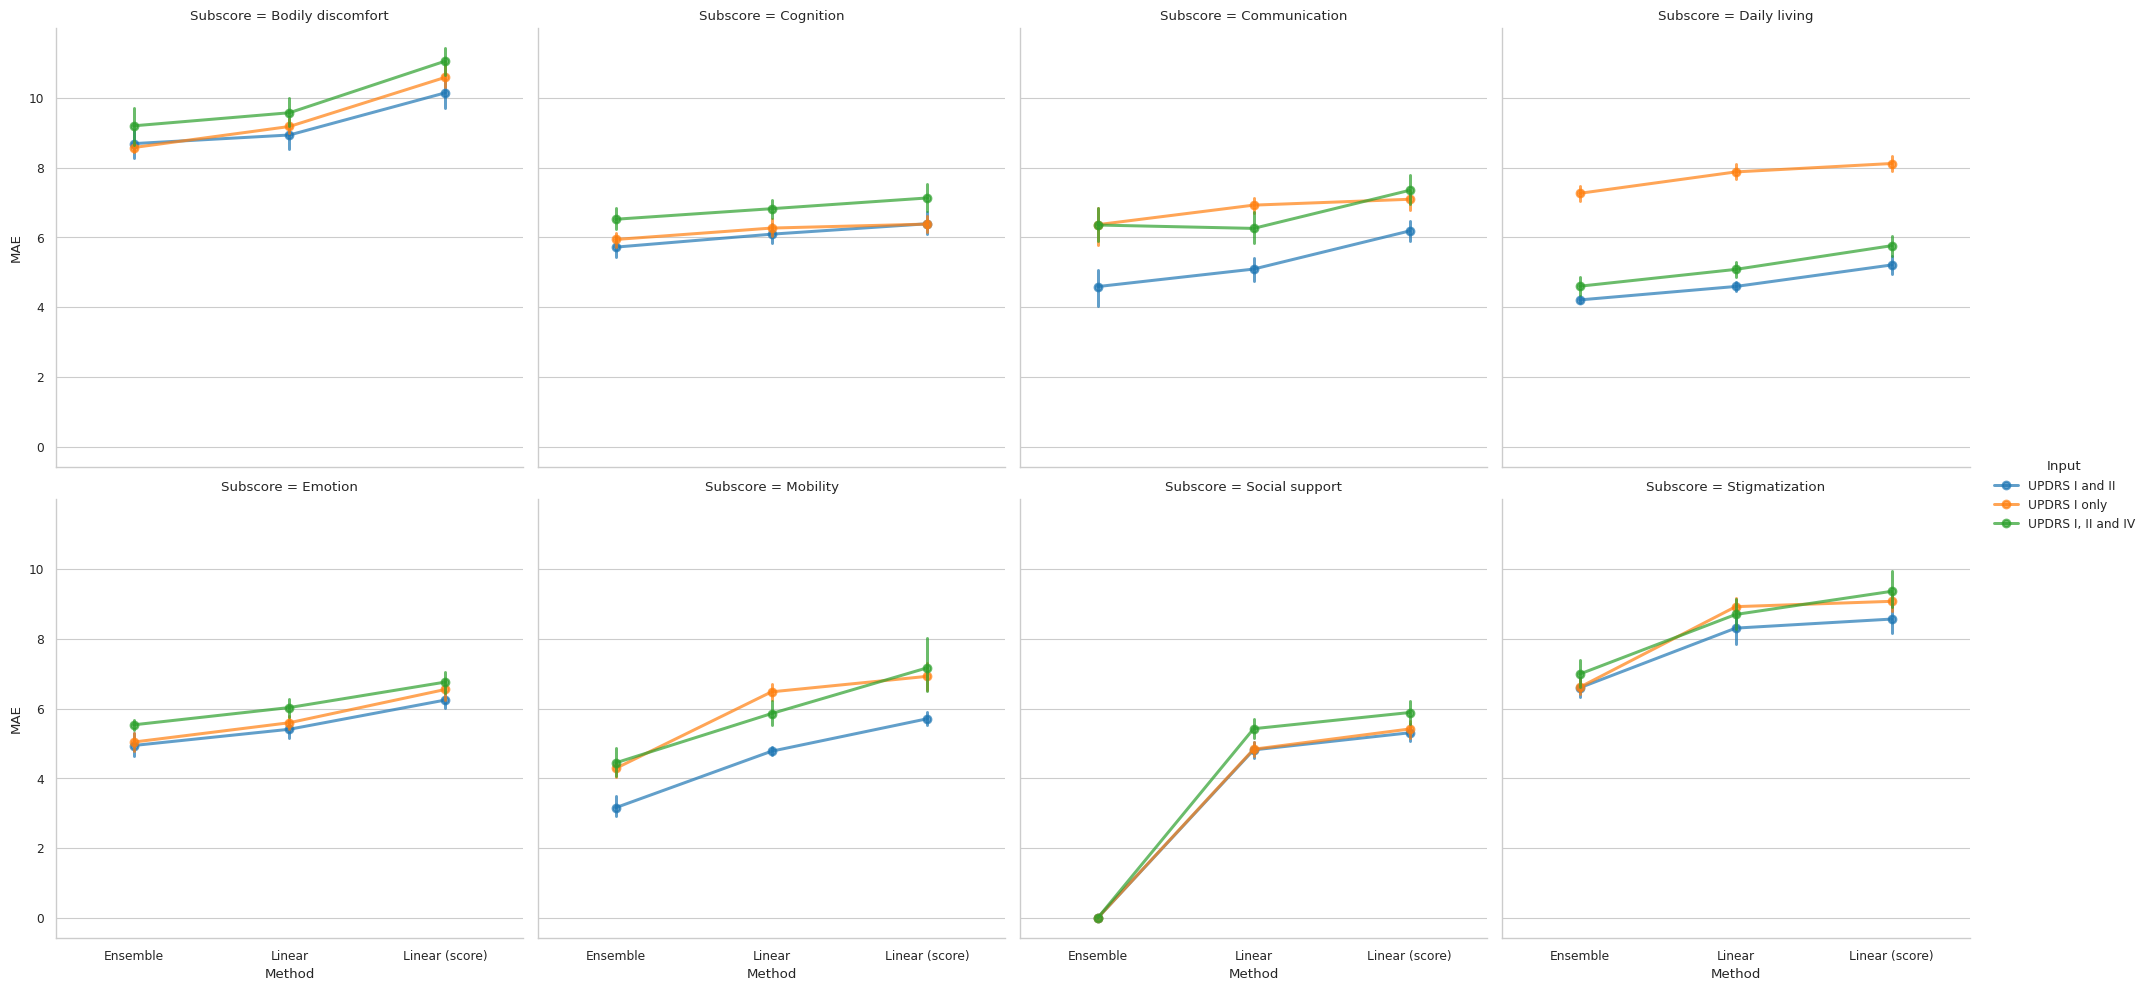

In [12]:
subscore_median_absolute_error_agg = []
for subscore, subscore_data in subscores_results.groupby("Subscore"):
    for input, input_data in subscore_data.groupby("Input"):
        for name, method_data in input_data.groupby("Method"):
            folds = method_data.groupby("Fold")
            subscore_median_absolute_error_agg.append(
                pd.DataFrame.from_dict(
                    {
                        "Method": name,
                        "Input": input,
                        "MAE": [
                            median_absolute_error(
                                y_true=fold["Ground truth"],
                                y_pred=fold["Prediction"],
                            )
                            for _, fold in folds
                        ],
                        "Subscore": subscore,
                        "Fold": range(len(folds)),
                    }
                )
            )
subscore_median_absolute_error_agg = pd.concat(subscore_median_absolute_error_agg)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.catplot(
        data=subscore_median_absolute_error_agg,
        x="Method",
        y="MAE",
        hue="Input",
        alpha=0.7,
        kind="point",
        col="Subscore",
        col_wrap=4
    )

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float64).
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float64).
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wro

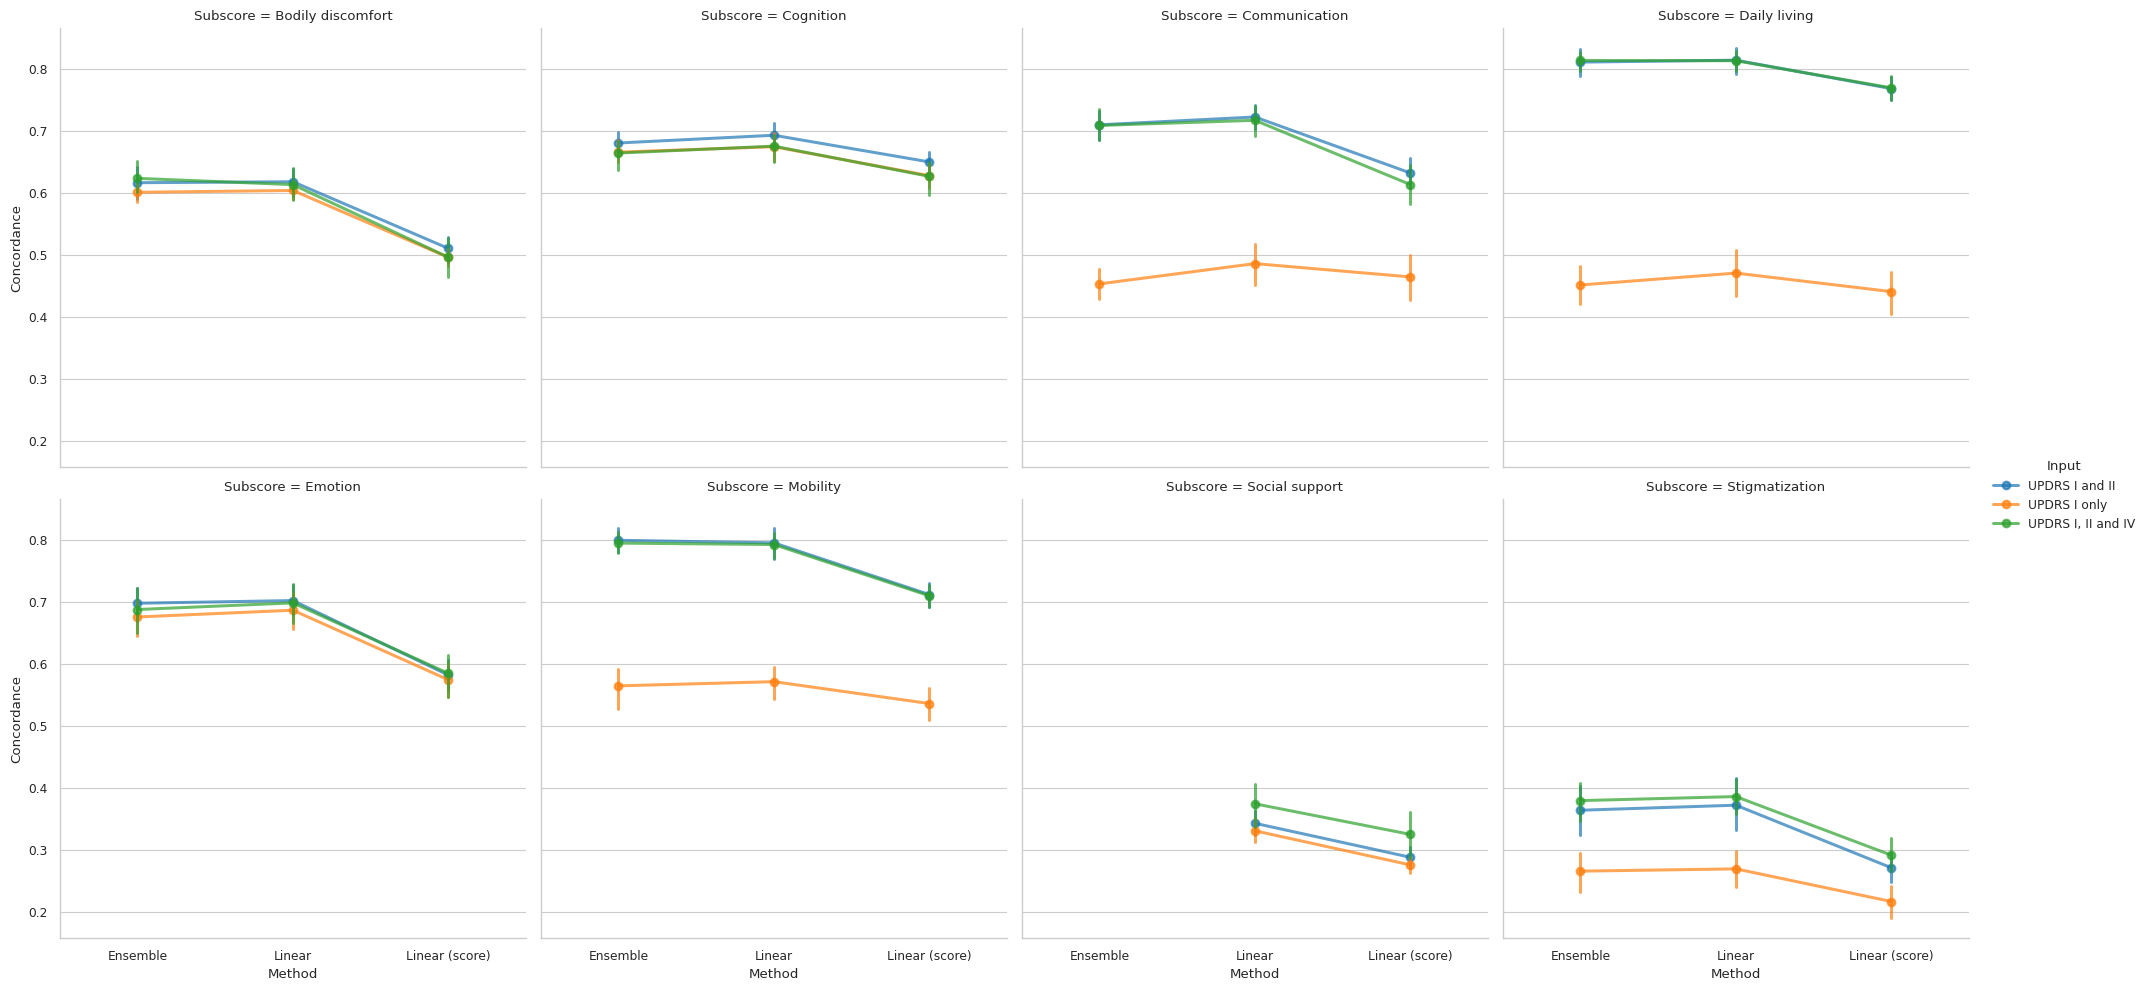

In [13]:
concordance_agg = []
for (method, input_data, subscore), data in subscores_results.groupby(
    ["Method", "Input", "Subscore"]
):
    concordance = [
        float(
            concordance_corrcoef(
                preds=torch.tensor(fold["Prediction"].astype(float).to_numpy()),
                target=torch.tensor(fold["Ground truth"].astype(float).to_numpy()),
            )
        )
        for _, fold in data.groupby("Fold")
    ]
    concordance_agg.append(
        pd.DataFrame.from_dict(
            {
                "Method": method,
                "Input": input_data,
                "Concordance": concordance,
                "Subscore": subscore,
            }
        )
    )
    
concordance_agg = pd.concat(concordance_agg, ignore_index=True)
with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    sns.catplot(
        data=concordance_agg,
        x="Method",
        y="Concordance",
        hue="Input",
        alpha=0.7,
        kind="point",
        col="Subscore",
        col_wrap=4,
    )

### Calculate values on test dataset

In [14]:
def load_testdata(path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    data = pd.read_csv(
        path,
        sep=",",
        na_values=[
            "Keine_Angabe",
            "Nicht_durchgeführt",
            "Keine_Angaben",
            "Keine_angabe",
        ],
    )
    pdq_columns = [column for column in data.columns if column.startswith("PDQ39 ")]
    updrs_columns = [
        column
        for column in data.columns
        if column.startswith("UPDRS 1.") or column.startswith("UPDRS 2.")
    ]
    data = data[pdq_columns + updrs_columns].dropna().reset_index(drop=True)
    return data[updrs_columns], data[pdq_columns]


test_updrs, test_pdq = load_testdata(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv"
)

ground_truth = torch.tensor(test_updrs.to_numpy(), dtype=torch.float32)
reconstruction = model(ground_truth.to("cuda")).x_recon
ground_truth_sum = ground_truth.sum(axis=-1).to("cuda")
reconstruction_sum = reconstruction.sum(axis=-1)

print(
    F.l1_loss(
        input=ground_truth.to("cuda"),
        target=model(ground_truth.to("cuda")).x_recon,
        reduction="none",
    )
    .sum(axis=-1)
    .mean()
    / (ground_truth.shape[-1])
)
print(
    (
        (ground_truth.to("cuda") != model(ground_truth.to("cuda")).x_recon).sum(axis=-1)
        / ground_truth.shape[-1]
    ).median()
)
print(
    concordance_corrcoef(
        target=ground_truth_sum.to(torch.float),
        preds=reconstruction_sum.to(torch.float),
    )
)

tensor(0.2041, device='cuda:0')
tensor(0.1538, device='cuda:0')
tensor([0.9717], device='cuda:0')
